# Table of contents
* [Introduction](#Introduction)
* [Getting data](#Getting-data)
    * [Importing spatial data](#Import-supporting-data:-House-price-and-spatial-data)
* [Extreme value modelling](#Statistical-analysis:-generalized-extreme-value-distribution)
* [Results](#Results)

# Introduction  [🡡](#Table-of-contents)

In [1]:
#import arviz as az
#import matplotlib.pyplot as plt
#import numpy as np
import geopandas as gpd
import os
import pandas as pd

import importlib
from gev_utils import DataImportUtils, PlottingUtils
#importlib.reload(DataImportUtils)

# Getting data 

DataImportUtils and PlottingUtils are custom modules. DataImportUtils scrapes and parses the data into a<br> usable format, PlottingUtils contain classes used to visualise data.

In [2]:
scraper = DataImportUtils.WebScraper(
'https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data')

results = scraper.get_data()

Braemar No 2 was relocated during the timeseries.
Southampton Mayflower Park was relocated during the timeseries.


Parse the coordinates for stations with metadata in a nonstandard format by hand ('Lowestoft<br> Monckton Avenue', 'Nairn Druim', 'Whitby')

In [3]:
lat, lon = 52.483, 1.727
results['Lowestoft Monckton Avenue'].extend([lat, lon])

lat, lon = 57.593, -3.821
results['Nairn Druim'].extend([lat, lon])

lat, lon = 54.481, -0.624
results['Whitby'].extend([lat, lon])

<div class="alert alert-block alert-info">
<b>NB:</b> Rainfall data scraped from the metoffice needs to be put into a uniform format. For example the dataset<br> contained several different ways of representation missing data, slightly different column names between<br> sites etc. <code>DataImportUtils.DataMunger</code> consists of methods to create a consistent dataset.
</div>

In [4]:
tidier = DataImportUtils.DataMunger(results)
tidier.tidy_data();
tidier.save_data('outputs')

FileExistsError: [Errno 17] File exists: 'outputs'

In [ ]:
# Extract a DataFrame of station coordinates 
# pd.DataFrame(tidier.station_coords_list, columns=['Station name', 'Lat', 'Lon']).to_csv('station_coords.csv')
pd.DataFrame(tidier.station_coords_list, columns=['Station name', 'Lat', 'Lon']).head()

In [ ]:
# Retrieve previously scraped Met station data
data_dir = 'outputs'
fnames = [f for f in os.listdir('data') if f.endswith('.csv')]
data_dict = {}
for each_fname in fnames:
    data_dict[each_fname.split('.')[0]] = pd.read_csv(os.path.join(data_dir,
                                                        f'{each_fname}'),
                                                      index_col='Date',
                                                      parse_dates=['Date'])

# sort sites alphabetically
data_dict = dict(sorted(data_dict.items()))

# remove Ringway (outlier, questionable rainfall data quality, 1960-2005)
del data_dict['Ringway']

## <center>[Return to top 🡡](#Table-of-contents)</center>

# Import supporting data: House price and spatial data

In order to incorporate risk into the analysis average house price data needs to
be imported and joined to<br> areas which have met stations. Finally spatial data
needs to be attached to describe the geographical extent of<br> each area/region.

In [5]:
# This .csv contains average house prices by administrative unit
house_price_df = pd.read_csv('Average-prices-2025-04.csv', index_col='Date')

# truncate house price data to 1 day and drop unneeded columns
house_price_df = house_price_df.loc['2025-04-01':'2025-04-01', ['Region_Name',
                                                                'Average_Price']
    ]

# Import spatial information on adminstrive boundaries in the UK as the house 
# price data is not spatial aware
admin_boundaries_gdf = gpd.read_file('GBR_adm.zip', layer='GBR_adm2')
house_price_gdf = admin_boundaries_gdf.merge(house_price_df, left_on='NAME_2',
                                             right_on='Region_Name', how='left')

In [6]:
# Create a GeoDataFrame of met station coordinates and set to the same
# coordinate reference system as the house price GeoDataFrame
station_coords_df = pd.read_csv('station_coords.csv')
station_coords_gdf = gpd.GeoDataFrame(station_coords_df,
                         geometry=gpd.points_from_xy(station_coords_df.Lon,
                                                     station_coords_df.Lat),
                                      crs=house_price_gdf.crs
                                     )

## <center>[Return to top 🡡](#Table-of-contents)</center>

# Statistical analysis: generalized extreme value<br> distribution

Annual maxima from the dataset are used as extreme values. `PyMC` was used to
build a Bayesian GEV model and predict the posterior distribution for extreme 
rainfall events. The advantage of using a Bayesian approach is that uncertainty
is incorporated into the anaylsis as we find a distribution as opposed to just 
point estimates. Samples can then be drawn from the posterior distribution
to gain insights into the particular scenarios. In this notebook, the magnitude
for a 20-year rainfall event for each station was examined. The posterior 
distribution was then used to make predictions based on a 20-year return period
and the 95% highest density interval was used to incorporate uncertainty into
the final risk estimates.

**References**: Based on Jorn Mossel's [PyData 2023 presentation](https://github.com/jjmossel/extremeweather/blob/main/PyData2023_JornMossel_Modeling%20Extreme%20Events%20with%20PyMC.pdf)

In [9]:
import arviz as az
import matplotlib.pyplot as plt
import multiprocessing # To stop connection time out error on Fedora 41 when 
                       #initiating MCMC sampler from pymc
import numpy as np
import pymc as pm
import pymc_extras.distributions as pmx

# much slower to start but prevents 'connection reset error'
multiprocessing.set_start_method('spawn', force=True)

Modelling approach
Fit the GEV equation using PyMC
For each site pass in extreme values (annual maxima)<br>
`pm.Model` finds the most like parameters to produce the observed values for
location (mu), scale (sigma) and shape (xi).

|Parameter|Distribution|Starting<br> value|Rationale|
|:-------:|:----------:|:----------------:|:-------:|
|Location|Normal|Median|Reduce prior by using weakly informative priors as possible|
|Scale|Half normal|Standard deviation| Values must be positve so the half normal distribution was used|
|Shape|Truncated normal|0 (+/- 0.5)| Values for shape will most likely follow the Weibull distrition and slightly negative, but close to 0|

After model interference, each station's posterior distribution was used to
make predictions. In this notebook the return intensity of extreme rainfail \[mm]
events was predicted for 100 years along with the 95% HDI which gives the 
uncertainty associated with each predicted value. A return period of 20-years
was chosen for further examination (as most stations have upwards of 20-years
of measurements). The uncertainty of prediction of return intensity, along with
house price data was used as the basis for generating a risk-based assessment
of different regions which includes a measure of uncertainty.

In [10]:
def build_model(df):
    """Build generalized extreme value model."""

    mu_estimate = df.median().to_numpy()
    sigma_estimate = df.std().to_numpy()
    with pm.Model() as model:
        # priors
        mu = pm.Normal('mu', mu=mu_estimate, sigma=10) # location
        sigma = pm.HalfNormal('sigma', sigma=sigma_estimate) # scale
        xi = pm.TruncatedNormal('xi', mu=0, sigma=.002, lower=-0.5,
                                upper=0.5) # shape
    
        # estimation
        gev = pmx.GenExtreme('Rainfall', mu=mu, sigma=sigma, xi=xi,
                             observed=df.to_numpy())
        idata = pm.sample_prior_predictive(draws=50, random_seed=42)
    return model, idata, mu, sigma, xi

def run_inference(model, idata):
    """Sample from model"""
    with model:
        idata.extend(pm.sample(
            1000,
            cores=4,
            chains=4,
            tune=300
        ))
    return idata

def get_posterior_predictive(model, idata):
    """Sample from the posterior predictive and add to model inference object."""
        
    with model:
        pm.sample_posterior_predictive(idata, extend_inferencedata=True,
                                       random_seed=42)

    return model, idata

def predict_return_period_and_intensity(model, idata, mu, sigma, xi):
    """Use the pp to predict return period and intensity for 100 years."""
    
    return_periods = np.logspace(
        1, 2, num=idata.posterior_predictive.Rainfall.shape[2])
    
    with model:
        rp = pm.Data("rp", return_periods) # period
        ri = pm.Deterministic("ri", mu - sigma/xi 
                              * (1 - (-np.log(1 - 1/rp)) ** (-xi))) # intensity
        post_pred = pm.sample_posterior_predictive(idata, var_names=['ri'])

    return post_pred, rp, ri, return_periods

def fit_gev(df):
    """Build model and run inference. This function returns a dictionary
    containing: the model, an inference object, the posterior predictive,
    the return periods used to generate the return intensity, the return
    intensity i.e. mm of rainfaill, the mean prediction, 95% ETI HDI (lower,
    upper) and the full arviz.summary object."""

    model, idata, mu, sigma, xi = build_model(df)
    idata = run_inference(model, idata)
    model, idata = get_posterior_predictive(model, idata)
    post_pred, rp, ri, return_periods = predict_return_period_and_intensity(model, idata, mu, sigma, xi)
    y_data = az.summary(post_pred.posterior_predictive, var_names='ri', hdi_prob=0.95)
    results_dict = {'model': model, 'idata': idata, 'post_pred': post_pred,
                    'return periods': return_periods, 
                    'return intensity': y_data['mean'],
                    'Lower': y_data['hdi_2.5%'],
                    'Upper': y_data['hdi_97.5%'],
                    'az_summary': y_data
                   }
    return results_dict

In [11]:
# Fit the GEV distribution to each dataset and put results in a dict
gev_dict = {}
for each_site, each_df in tidier.get_extreme_dict(data_dict).items():
    print(f'Processing {each_site}')
    gev_dict[each_site] = fit_gev(each_df)

Processing Aberporth


Sampling: [Rainfall, mu, sigma, xi]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 33 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Armagh


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Ballypatrick Forest


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 33 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Bradford


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 34 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Braemar No 2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 34 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Camborne


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 33 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Cambridge Niab


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Cardiff Bute Park


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Chivenor


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Cwmystwyth


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Dunstaffnage


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Durham


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Eastbourne


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Eskdalemuir


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Heathrow


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Hurn


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Lerwick


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Leuchars


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Lowestoft Monckton Avenue


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Manston


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Nairn Druim


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Newton Rigg


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Oxford


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 41 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Paisley


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 39 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Ross-on-wye


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 39 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Shawbury


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Sheffield


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 41 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Southampton Mayflower Park


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 49 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Stornoway Airport


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 44 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Sutton Bonington


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 43 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Tiree


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 43 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Valley


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 43 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Waddington


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 42 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Whitby


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 42 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Wick Airport


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 43 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Yeovilton


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 42 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

In [463]:
# Add spatial & house price information to statistical results
importlib.reload(DataImportUtils)
geomunger = DataImportUtils.GeoMunger(house_price_gdf, station_coords_gdf)
geomunger.tidy_data(gev_dict);

## <center>[Return to top 🡡](#Table-of-contents)</center>

# Results

In [464]:
importlib.reload(PlottingUtils)
plotter = PlottingUtils.Plotter(geomunger.house_price, gev_dict, data_dict)

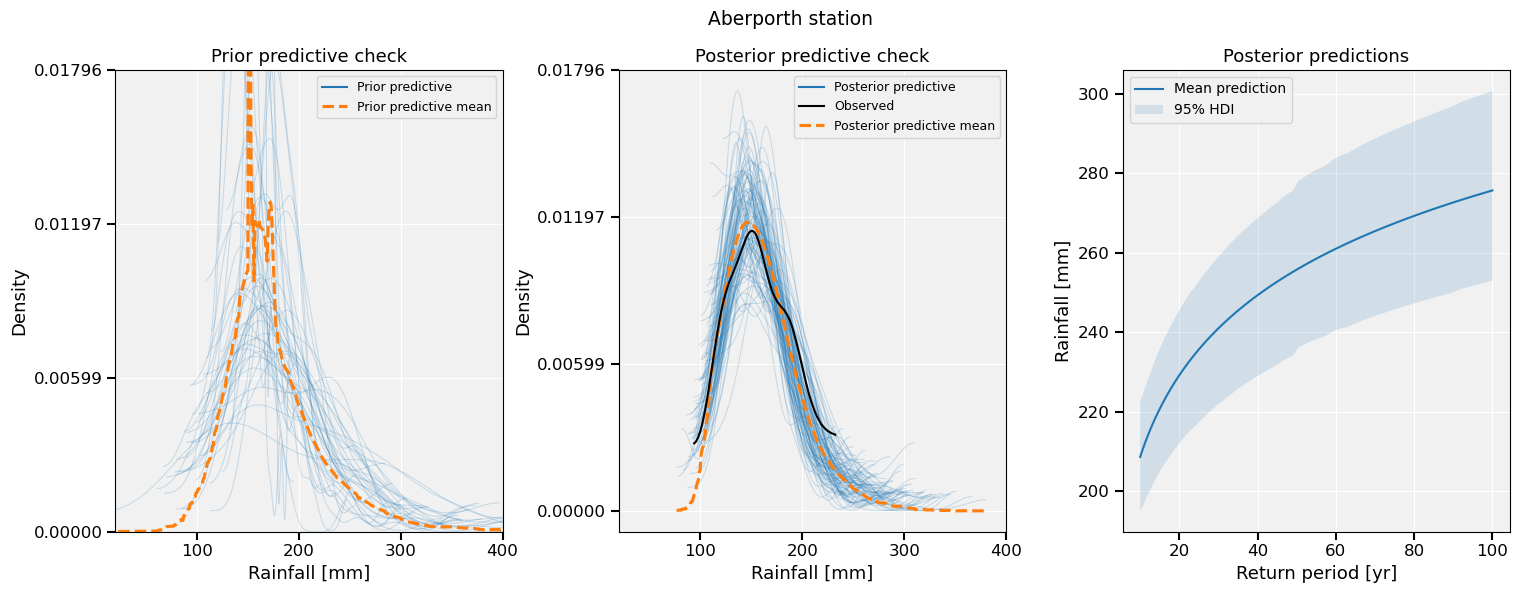

In [470]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
plotter.plot_prior_post_prediction('Aberporth', fig, axes);
fig.savefig('bayesian_modelling.png')

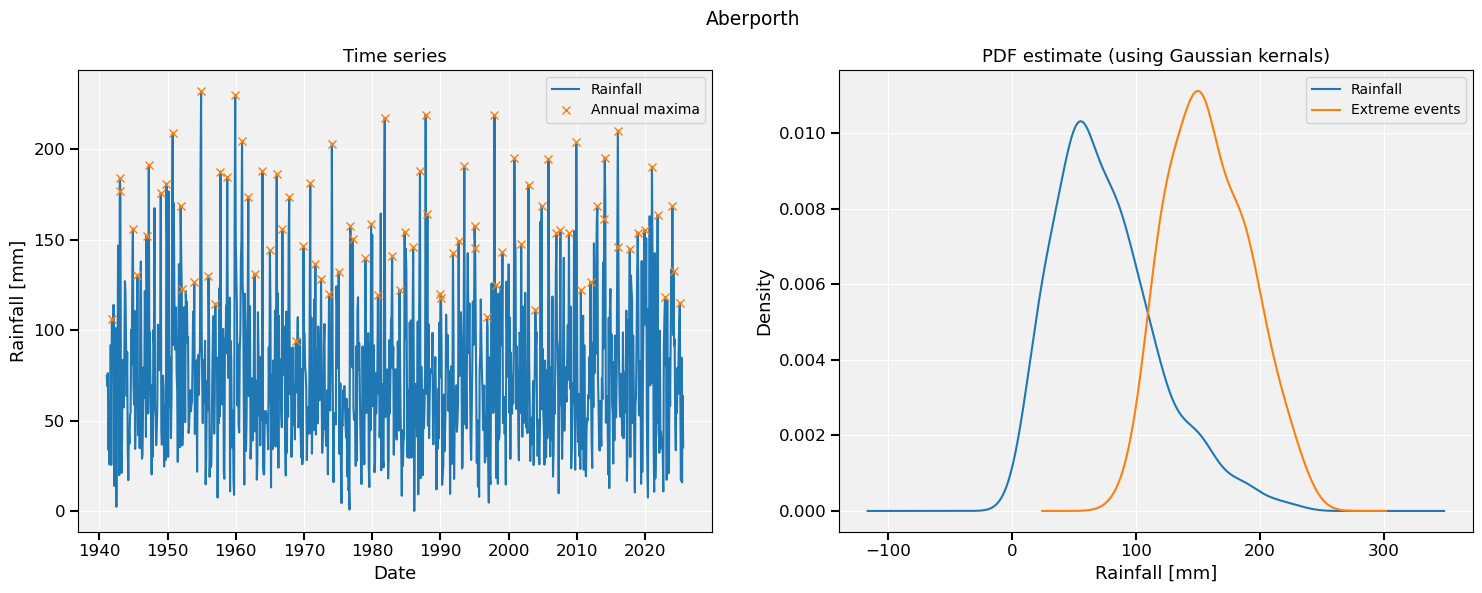

In [471]:
fig, axes = plt.subplots(ncols=2, figsize=(18,6))
plotter.plot_ts('Aberporth', fig, axes);
fig.savefig('ts_pdf_aberporth.png')

## Risk-adjusted house prices

For each regions where both average house price data and Met station was present, risk-adjusted house prices were calculated.
A minmax scaler was used to re-scale 20-year return intensity values to be between 0 and a user-specified upper bound. The upper bound of the
minmax scaler is effectively the risk weighting assigned to extreme rainfall events as its used to calculate an adjustment value to be added to house
price.
Adjustment-value = original price x minmax value
Risk-adjusted house price = original price + adjustment value

For an original house price of £80,000 and a minmax scaled rainfall value of 0.25, the adjustment amount would be £80,000 x 0.25 = £20,000,
giving a risk-adjusted house price of £100,000.

Finally, a user-specified option for a threshold below which no adjustedment takes place was added.

## Incorporating uncertainty

Uncertainty was incorporated by finding the ratio of the 95% HDI to the mean rainfall intensity prediction for a 20-year return period.
For example for a mean prediction of 100 mm, with a lower bound of 70 mm and an upper bound of 110 mm the ratios will be 0.7 and 1.1 
for the lower and upper bounds, respectively. After house prices had been risk-adjusted these ratios were used to calculate the lower
and upper bounds for these risk-adjusted house prices. To continue with the above example for a risk-adjusted house price of £100,000
the risk-adjusted house price would be £100,000 x 0.7 = £70,000 and the upper bound would be £100,000 x 1.1 = £110,000.

The user-specified values for the minmax scaler and the threshold allow different scenarios to easily be explored. For example for an application
where the risk of extreme rainfall events was considered to be high a value of 1.0 could be specified. Assuming that a station had the maximum return intensity, changing the minmax upper bound from 0.5 to 0.25 would result in the follwing changes to our example. If a station's return intensity is below the `threshold` for risk-adjustment, the original house price is return but the uncertainty from the rainfall prediction is incorporated to give lower and upper estimates for the house price.

|Threshold <br> & minmax upper bound | Average<br> house price | Return intensity | Minmax-scaled<br>return intensity | Uncertainty ratio<br>lower, upper| Risk-adjusted<br>house price<br>lower, upper|
|:---:|:---:|:---:|:---:|:---|:---:|
|120, 0.5| £100,000 | 160 \[mm] |£100,000 + (£100,000 x 0.5) = £150,000|\[0.7, 1.1]|£100,000 + (£100,000 x 0.5) = £150,000 <br>\[£105,000 - £165,000] |
|120, 0.25| £100,000 | 160 \[mm] |£100,000 + (£100,000 x 0.25) = £125,000|\[0.7, 1.1]|(£100,000 x 0.25) = £125,000 <br>\[£87,000 - £137,000] |
|180, 0.25| £100,000 | 160 \[mm] |£100,000 (no adjustment < threshold) = £100,000|\[0.7, 1.1]|£100,000 (no adjustment < threshold) = £100,000<br>\[£70,000 - £110,000] |
|180, 0.5| £100,000 | 160 \[mm] |£100,000 (no adjustment < threshold) = £100,000|\[0.7, 1.1]|£100,000 (no adjustment < threshold) = £100,000<br>\[£70,000 - £110,000] |

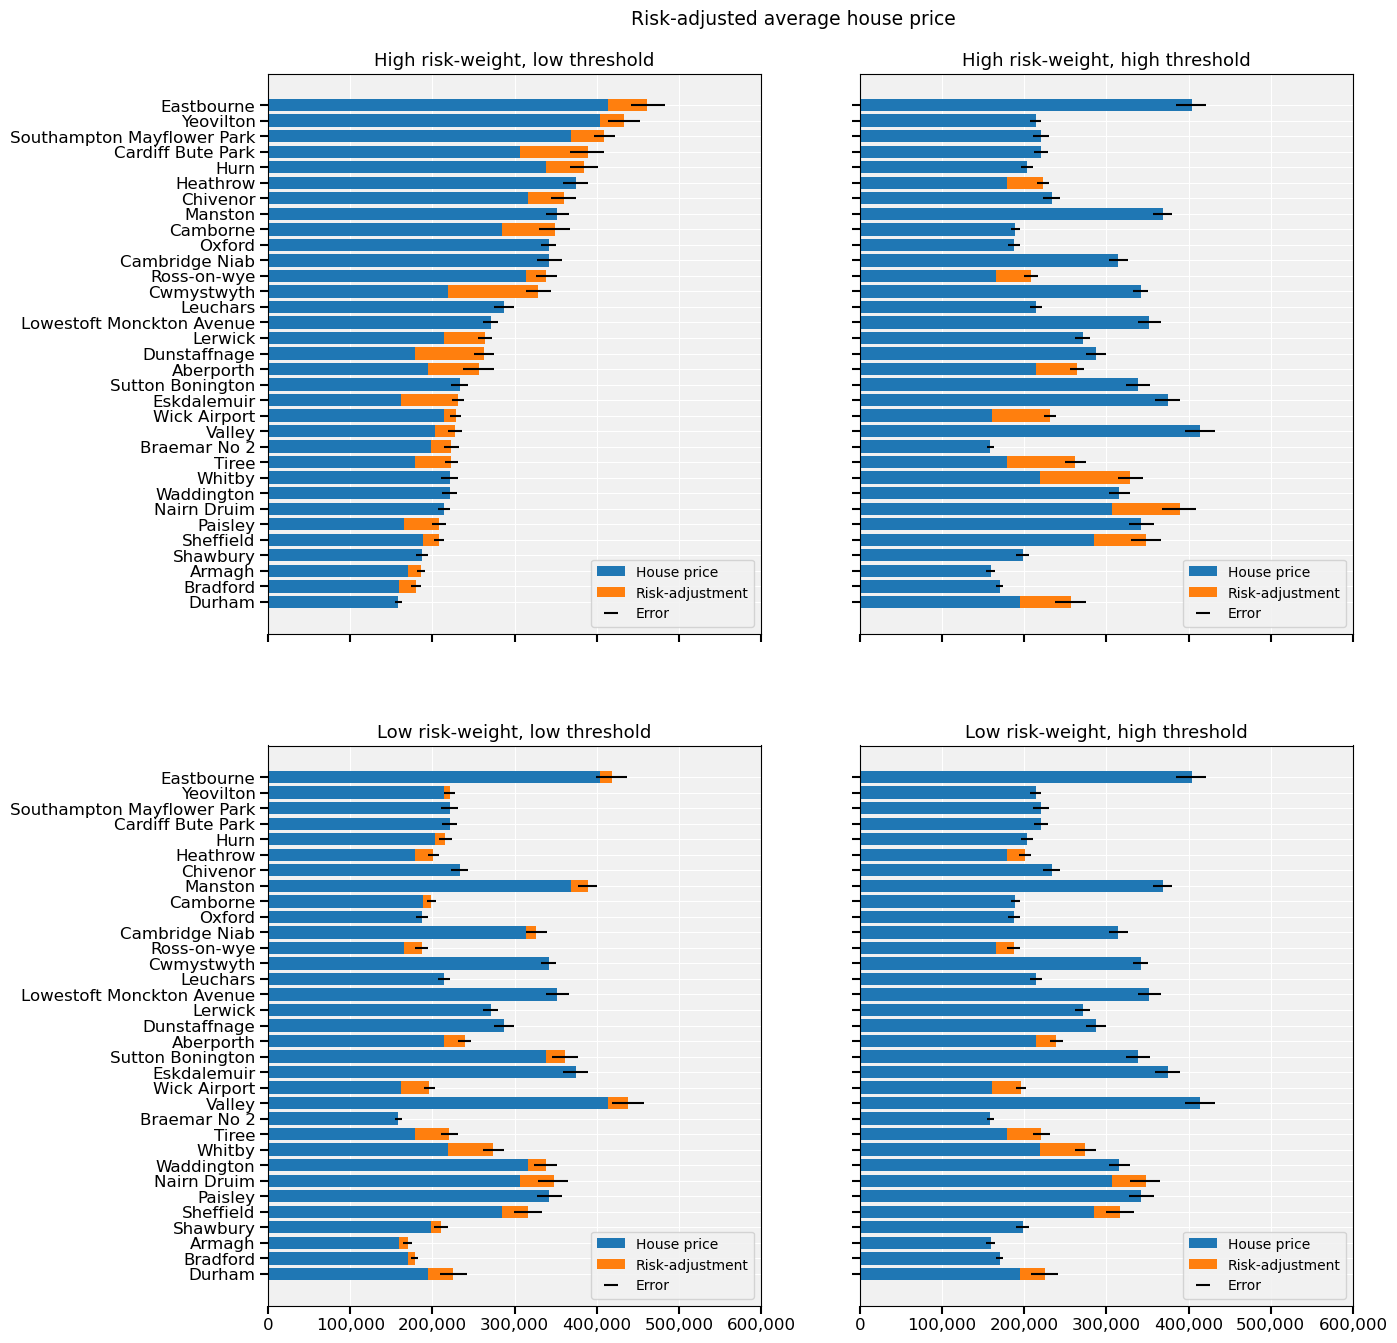

In [472]:
df_120_5 = geomunger.get_risk_adj_df(risk_threshold=120, risk_weight=.5)
df_120_25 = geomunger.get_risk_adj_df(risk_threshold=120, risk_weight=.25)
df_180_25 = geomunger.get_risk_adj_df(risk_threshold=180, risk_weight=.25)
df_180_5 = geomunger.get_risk_adj_df(risk_threshold=180, risk_weight=.5)

fig, axes = plt.subplots(figsize=(14,16), nrows=2, ncols=2, sharey='row', sharex=True) #
axes = axes.flatten()
scenarios = {'High risk-weight, high threshold': df_180_5,
             'Low risk-weight, low threshold': df_120_25,
             'Low risk-weight, high threshold': df_180_25,
            }
base_scenario = ['High risk-weight, low threshold', df_120_5]
fig, axes[0], index = plotter.plot_risk_adj_bar(base_scenario[1].sort_values(by='Risk-adjusted house price', ascending=True), fig, axes[0])
axes[0].set_title(base_scenario[0])
for idx, each_item in enumerate(scenarios.items(), 1):
    plotter.plot_risk_adj_bar(each_item[1], fig, axes[idx], index)
    axes[idx].set_title(each_item[0])
    axes[idx].set_xticks(axes[idx].get_xticks())
    axes[idx].set_xticklabels(['{:,}'.format(int(x)) for x in axes[idx].get_xticks().tolist()])
fig.suptitle('Risk-adjusted average house price', y=0.92);
fig.savefig('risk_adjusted_house_price_grid.png')

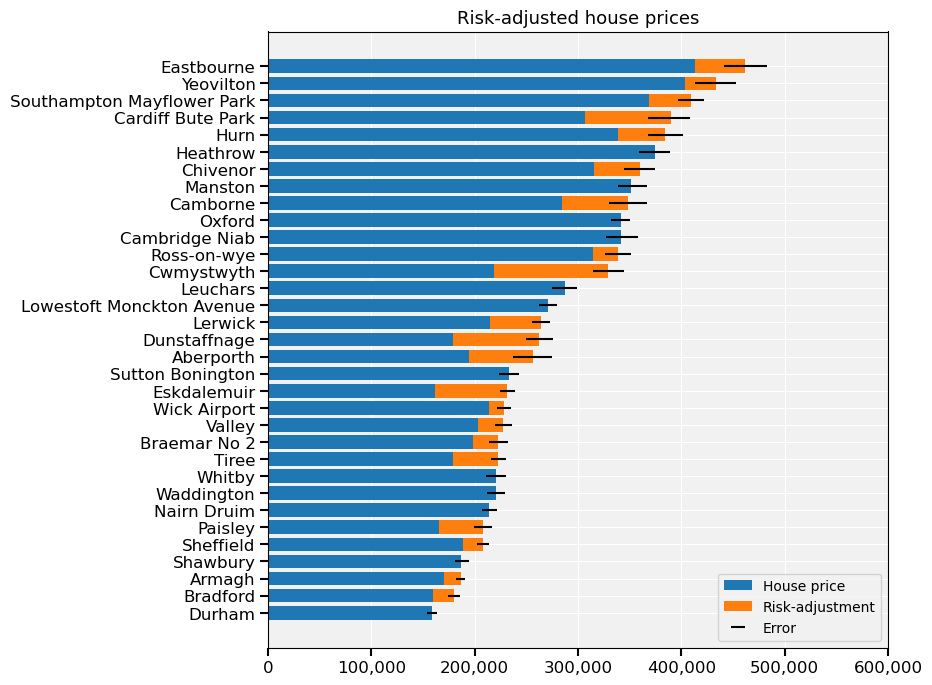

In [473]:
fig, ax = plt.subplots(figsize=(8,8))
plotter.plot_risk_adj_bar(df_120_5.sort_values(by='Risk-adjusted house price', ascending=True), fig, ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()]);
fig.savefig('risk_adjusted_house_single.png')

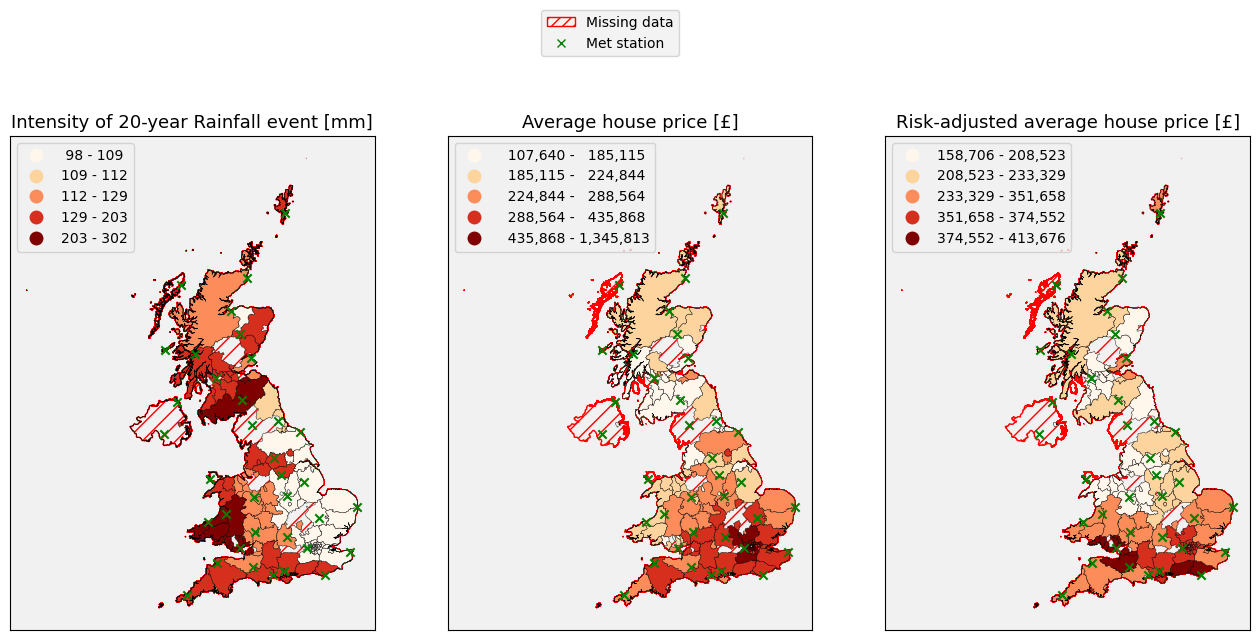

In [474]:
fig, axes = plt.subplots(ncols=3, figsize=(16,8))
plotter.plot_choropleth(geomunger, fig, axes);
fig.savefig('choropleth.png')

## <center>[Return to top 🡡](#Table-of-contents)</center>

Summary
When incorpating risk, London areas have less risk. Wales which has a much haigher
chance of extreme rainfall events has a lower risk due to the lower house values

In [480]:
scraper.station_dict['Aberporth'][2]

['Aberporth\r\n',
 'Location: 224100E 252100N, Lat 52.139 Lon -4.570, 133 metres amsl\r\n',
 'Estimated data is marked with a * after the value.\r\n',
 'Missing data (more than 2 days missing in month) is marked by  ---.\r\n',
 'Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.\r\n']

In [ ]:
# task
# write up explanation of how risk and error bounds were created
# write doc strings for all methods
# look up template for docstring (call signature etc)
# add blub to modules

# save figures
# write up cover letter
# put into latex
# update cv (remove personal website)